In [1]:
import graph_tool.all as gt
import plotly.graph_objects as go
import cloudpickle as pickle
import pandas as pd
import numpy as np
import multiprocessing as mp
import sys
sys.path.append("../hSBM_Topicmodel/")
sys.path.append("../trisbm/")
from topicpy.hsbmpy import get_scores, get_scores_shuffled, normalise_score
from sklearn.metrics import adjusted_mutual_info_score, rand_score, v_measure_score

In [2]:
experiments = ["APS", "Wikipedia", "Twitter", "Plos", "BRCA", "TCGA"]
stores = ["aps", "wikipedia", "twitter", "plos", "tcga", "tcga"]
eval_labels = [["journal"], ["Topic"], ["kind"], ["journal"], ["Subtype_Selected"], ["cases.0.project.primary_site"]]

In [40]:
all_scores = {}

def get_experiment_scores(experiment, store, labels):
    scores = get_scores(f"{experiment}/{store}_key", labels, algorithm="trisbm", verbose=False, metric=v_measure_score)
    scores['trisbm'] = scores[labels[0]]
    scores["hsbm"]=get_scores(f"{experiment}/{store}", labels, algorithm="topsbm", verbose=False, metric=v_measure_score)[labels[0]]
    df_files = pd.read_csv(f"{experiment}/{store}/files.dat", sep=",", index_col=0)
    scores['shuffle'] = get_scores_shuffled(f"{experiment}/{store}", df_files,  label=labels[0], algorithm='topsbm', metric=v_measure_score)
    shuffles = []
    for _ in range(10):
        shuffles.append(get_scores_shuffled(f"{experiment}/{store}", df_files, label=labels[0], algorithm='topsbm', metric=v_measure_score)["V"])
    
    scores['shuffle']["V"] = np.average(shuffles, axis=0)
    normalise_score(scores, base_algorithm="shuffle", operation=lambda x,y: x/y)
    return experiment, scores

def callback(X):
    global all_scores
    all_scores[X[0]]=X[1]
    
pool = mp.Pool(6)

w = [pool.apply_async(get_experiment_scores, args=((experiment, store, labels)), callback=callback, error_callback=lambda err:print(err))  for experiment, store, labels in zip(experiments, stores, eval_labels)]
pool.close()
pool.join()


In [4]:
all_scores[experiments[0]].keys()

dict_keys(['journal', 'trisbm', 'hsbm', 'shuffle'])

In [5]:
def get_score_area(score, experiment, metric="norm_V"):
    x = np.log10(10+np.array(score[experiment]["xl"]))
    y = np.array(score[experiment][metric])
    ix = np.argsort(x)
    return np.trapz(np.log10(x[ix]),y[ix])

In [41]:
fig = go.Figure()

sbmtm_scores = np.array([max(all_scores[experiment]["hsbm"]["norm_V"]) for experiment in all_scores.keys()])
trisbm_scores = np.array([max(all_scores[experiment]["trisbm"]["norm_V"]) for experiment in all_scores.keys()])

fig.add_traces([
    go.Bar(y=sbmtm_scores/trisbm_scores, name="hsbm"),
    go.Bar(y=trisbm_scores/trisbm_scores, name = "trisbm")
])

titlefont = {
    "size": 30 
}

tickfont = {
    "size":25
}

layout = {
    "title":"",
    "xaxis":{
        "title": "Dataset",
        "tickmode": "array",
        "tickvals": list(range(len(experiments))),
        "ticktext": experiments,
        "titlefont": titlefont,
        "tickfont": tickfont
    },
    "yaxis":{
        "title": "NMI/NMI* scaled",
        "titlefont": titlefont,
        "tickfont": tickfont,
    },
    "legend":{
        "font_size":35
    }
}

fig.update_layout(layout)
fig.show()
fig.write_image("NMIscaled_comparison.pdf", engine="kaleido")

In [7]:
import matplotlib.pyplot as plt
from topicpy.hsbmpy import add_score_lines

<ipython-input-42-5506a338e41c>:9: UserWarning:

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.



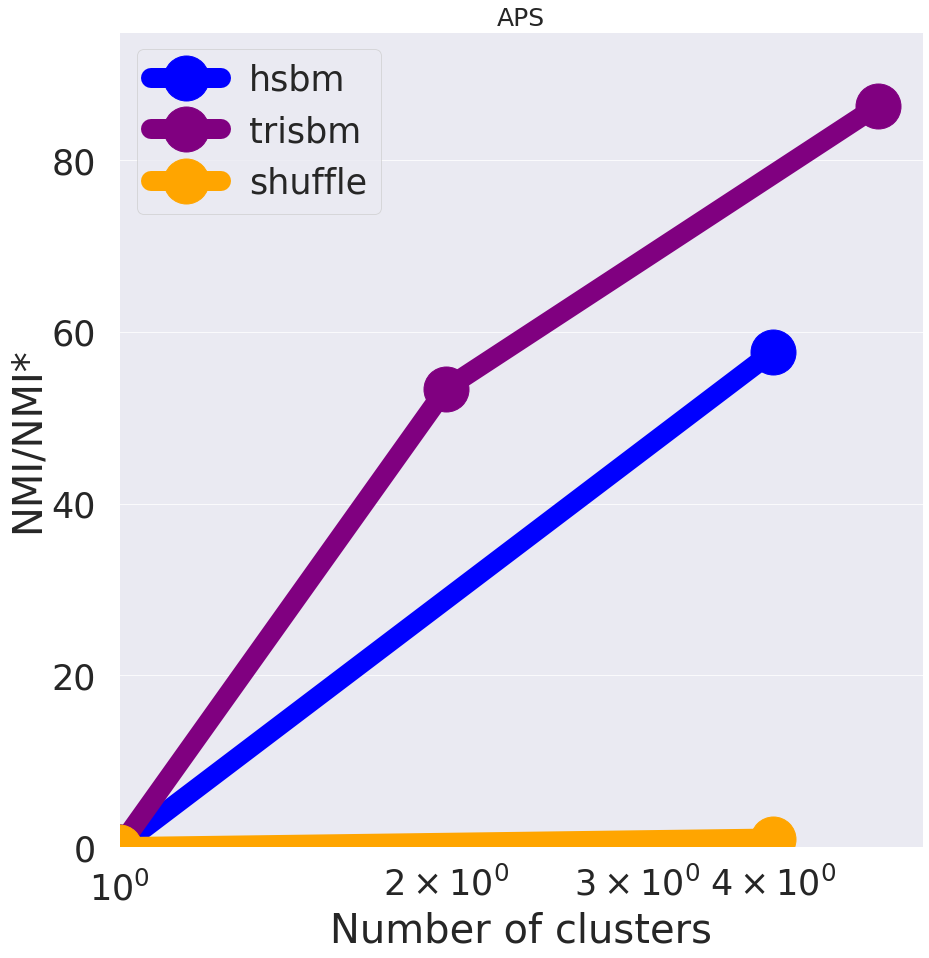

<ipython-input-42-5506a338e41c>:9: UserWarning:

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.



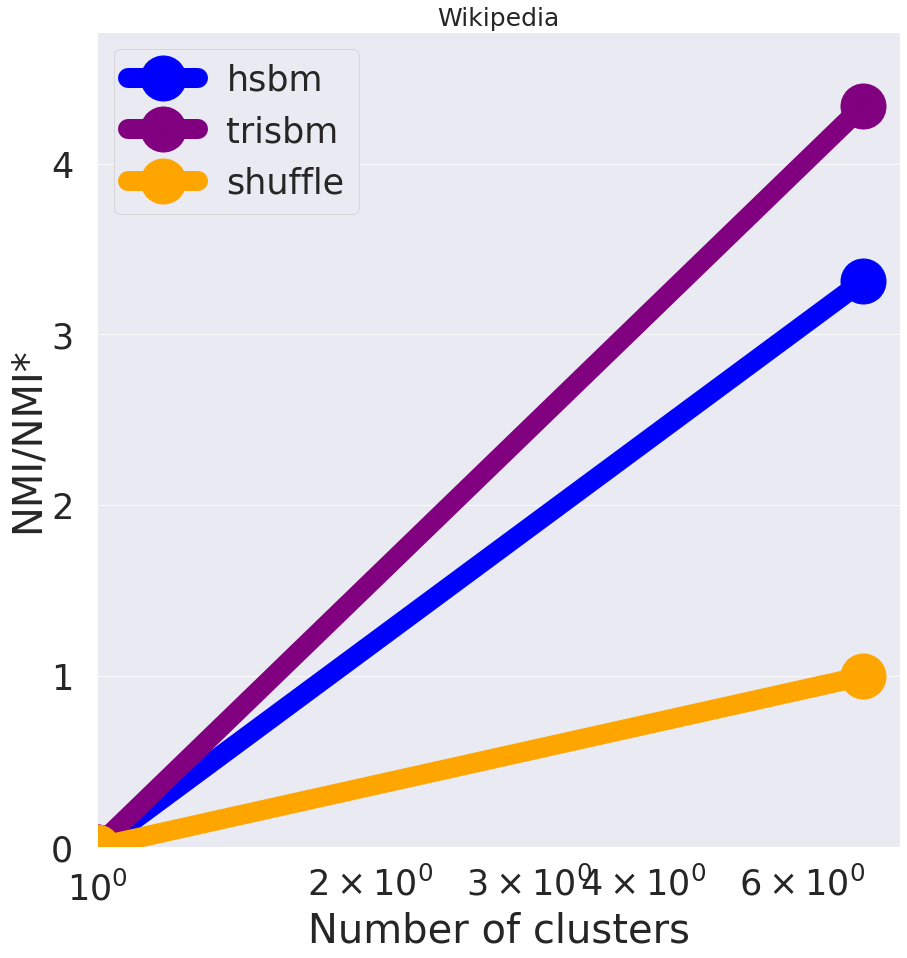

<ipython-input-42-5506a338e41c>:9: UserWarning:

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.



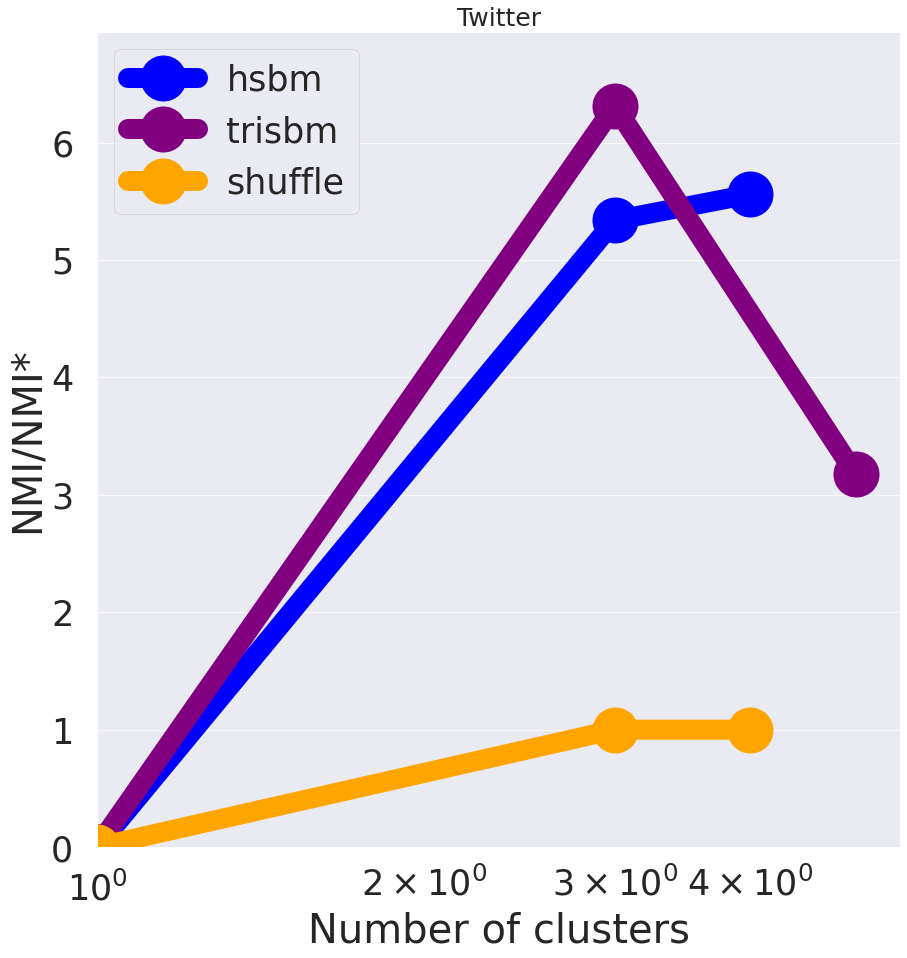

<ipython-input-42-5506a338e41c>:9: UserWarning:

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.



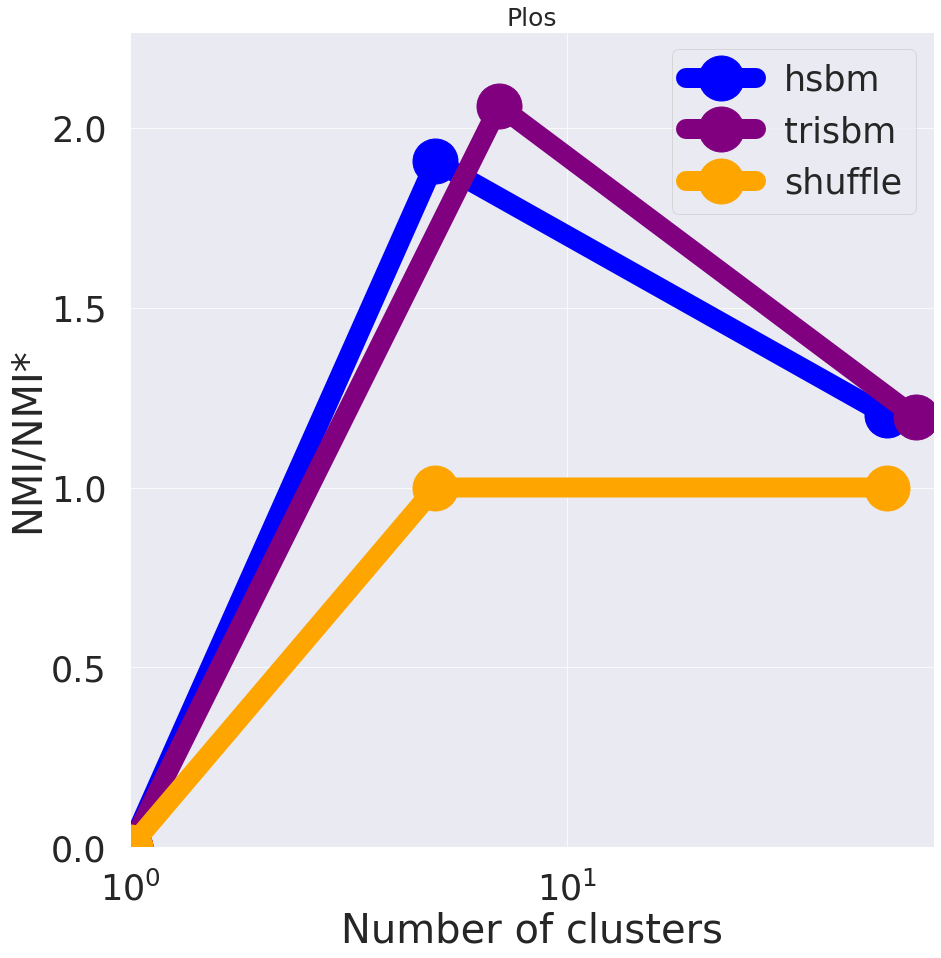

<ipython-input-42-5506a338e41c>:9: UserWarning:

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.



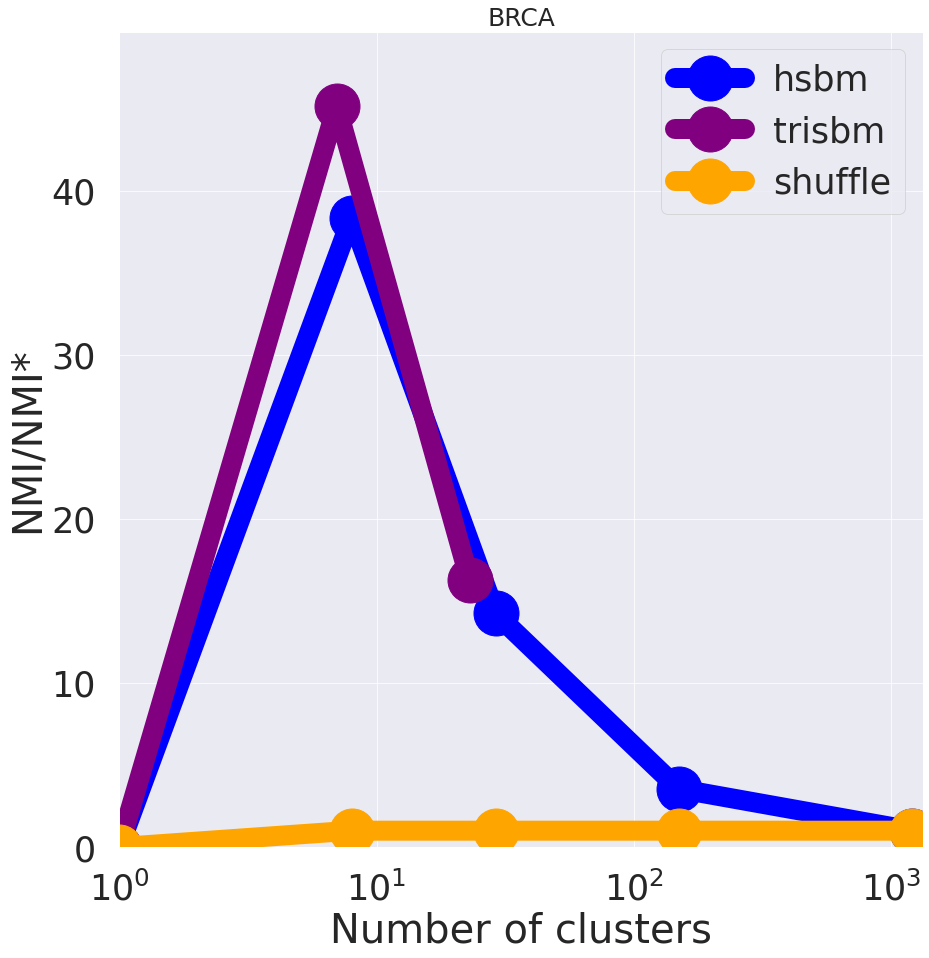

<ipython-input-42-5506a338e41c>:9: UserWarning:

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.



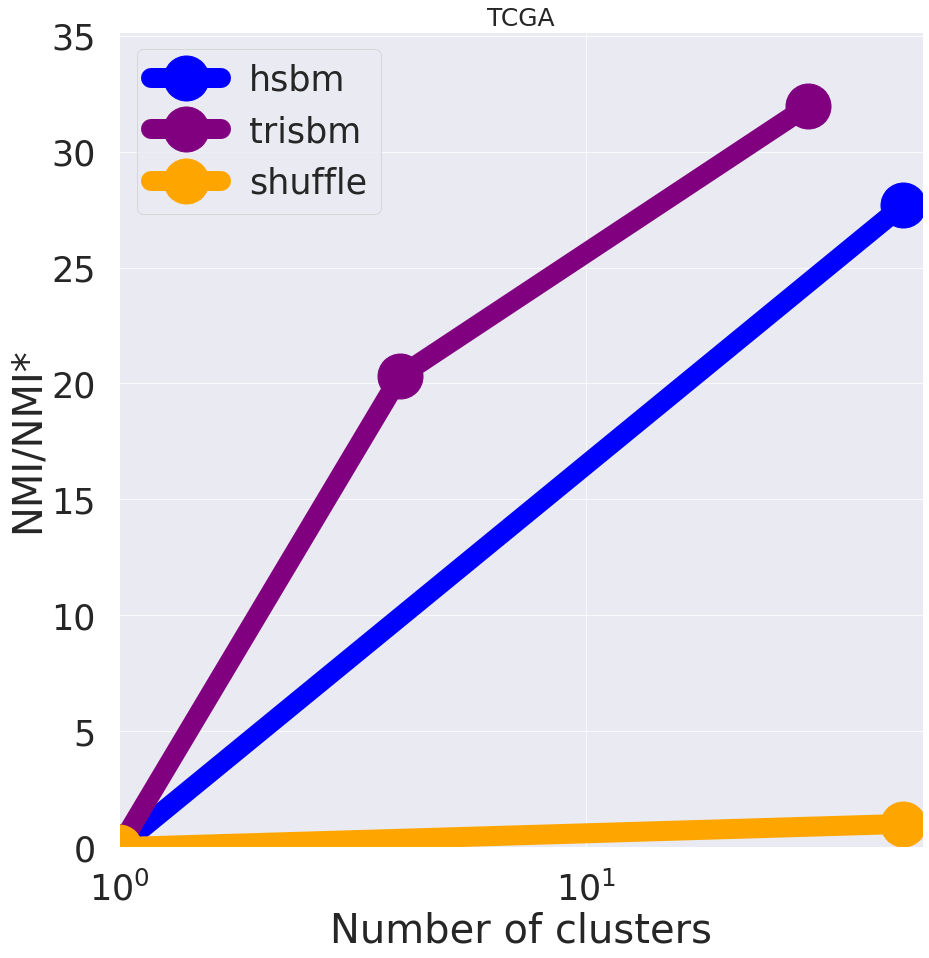

In [42]:
for experiment in experiments:
    scores = all_scores[experiment]
    fig=plt.figure(figsize=(18,15))
    ax = fig.subplots(1)
    add_score_lines(ax,scores,labels=["hsbm","trisbm", "shuffle"], V="norm_V", alpha=1)
    ax.set_title(experiment, fontsize=25)
    ax.set_xscale('log')
    ax.set_ylim(0,max(map(lambda s: max(s["norm_V"]), scores.values()))*1.1)
    ax.set_xlim(0,max(map(lambda s: max(s["xl"]), scores.values()))*1.1)
    ax.set_ylabel("NMI/NMI*")

    ax.lines[1].set_color("purple")
    ax.legend(fontsize=35)

    plt.show()
    fig.savefig("metric_scores_{}.pdf".format(experiment))

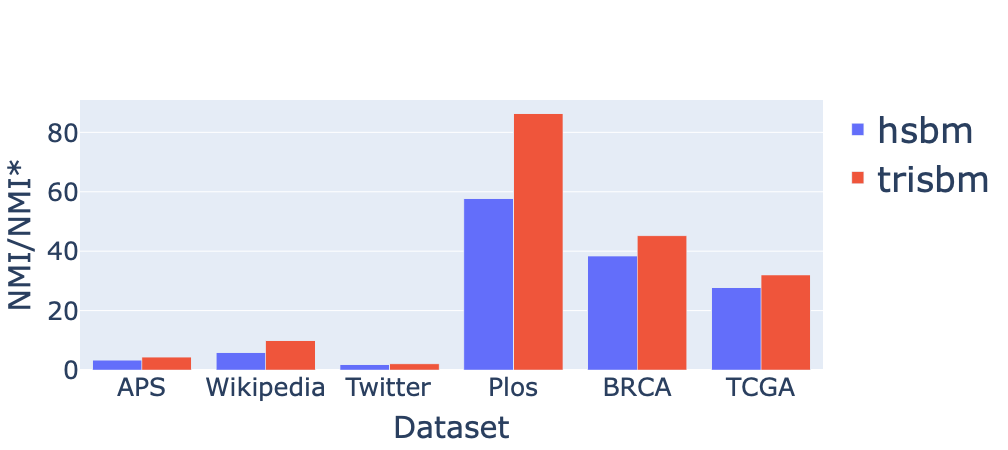

In [14]:
fig = go.Figure()

sbmtm_scores = np.array([max(all_scores[experiment]["hsbm"]["norm_V"]) for experiment in all_scores.keys()])
trisbm_scores = np.array([max(all_scores[experiment]["trisbm"]["norm_V"]) for experiment in all_scores.keys()])

fig.add_traces([
    go.Bar(y=sbmtm_scores, name="hsbm"),
    go.Bar(y=trisbm_scores, name = "trisbm")
])

titlefont = {
    "size": 30 
}

tickfont = {
    "size":25
}

layout = {
    "title":"",
    "xaxis":{
        "title": "Dataset",
        "tickmode": "array",
        "tickvals": list(range(len(experiments))),
        "ticktext": experiments,
        "titlefont": titlefont,
        "tickfont": tickfont
    },
    "yaxis":{
        #"type":"log",
        "title": "NMI/NMI*",
        "titlefont": titlefont,
        "tickfont": tickfont,
    },
    "legend":{
        "font_size":35
    }
}

fig.update_layout(layout)

fig.show()
fig.write_image("NMImax_comparison.pdf", engine="kaleido")

In [43]:
sbmtm_entropies = []
trisbm_entropies = []


for experiment in experiments:
    print(experiment)
    with open(f"{experiment}/sbmtm.pkl", "rb") as file:
        model = pickle.load(file)
        
    sbmtm_entropies.append(model.get_mdl()/model.g.num_edges())
    
    #print(model.g.num_edges(), np.sum(model.g.ep["count"].a))
    
    with open(f"{experiment}/trisbm.pkl", "rb") as file:
        model = pickle.load(file)
        
    trisbm_entropies.append(model.get_mdl()/model.g.num_edges())
          
    #print(model.g.num_edges(), np.sum(model.g.ep["count"].a))

APS
Wikipedia
Twitter
Plos
BRCA
TCGA


In [44]:
delta_Sigma = (np.array(trisbm_entropies) - np.array(sbmtm_entropies))*np.log10(np.exp(1))

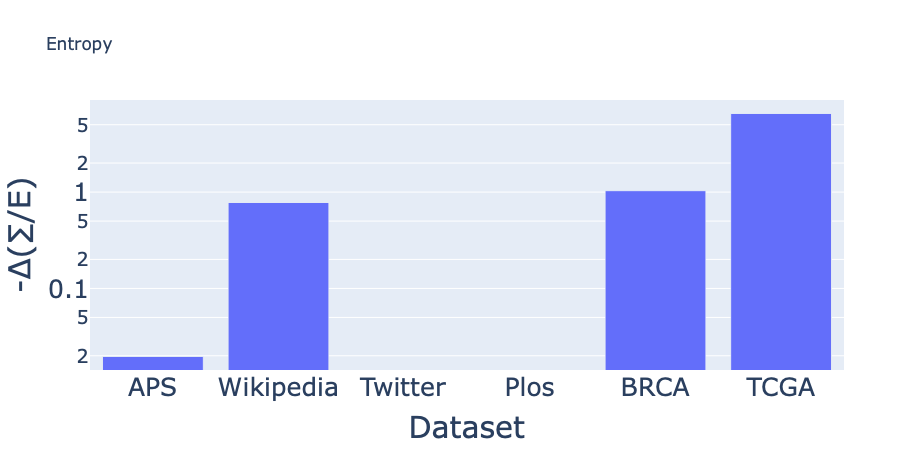

In [49]:
fig = go.Figure()

        
fig.add_traces([
    go.Bar(y=-delta_Sigma, name="hsbm"),
])

titlefont = {
    "size": 30 
}

tickfont = {
    "size":25
}

layout = {
    "title":"Entropy",
    "xaxis":{
        "title": "Dataset",
        "tickmode": "array",
        "tickvals": list(range(len(experiments))),
        "ticktext": experiments,
        "titlefont": titlefont,
        "tickfont": tickfont
    },
    "yaxis":{
        "title": "-Δ(∑/E)",
        #"range":[-3e4,1000],
        "type":"log",
        "titlefont": titlefont,
        "tickfont": tickfont,
    },
    "legend":{
        "font_size":35
    }
}

fig.update_layout(layout)

fig.show()
fig.write_image("entropy_comparison.pdf", engine="kaleido")